## Importing Required Packages

In [1]:
import numpy as np
import pandas as pd
from dateutil.parser import parse
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import chisquare
import itertools
import warnings

## Reading the dataset and basic preprocessing
This is a **Time Series Dataset** which stores the prices of oil from 29<sup>th</sup> October, 2014 to 29<sup>th</sup> October, 2019.

In [2]:
opec = pd.read_csv('OPEC-ORB.csv', parse_dates=['Date'], index_col='Date')
opec.head()

,Value
Date,
2019-10-29,61.44
2019-10-28,61.65
2019-10-25,62.16
2019-10-24,61.63
2019-10-23,60.42


The dataset does not contain any null values. The **Date** column was parsed into **Datetime** format to assist with time series analysis and forecasting.<br>
The dates recorded in this dataset are stored in decending order where the latest recording is displayed on the top. Just to preserve the intuitive chronology, the order of dates is inverted. 

In [3]:
opec.sort_values(by=['Date'], inplace=True)
opec.head()

,Value
Date,
2014-10-29,83.24
2014-10-30,82.79
2014-10-31,81.97
2014-11-03,80.64
2014-11-04,78.67


## Stationarity Check
There are in general, 3 ways of checking whether the given dataset is Stationary or not.

### Method 1 - Plot the data
In this approach we plot the data and judge whether the data is stationary or not based on intuition developed via pictorial representations.

C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\pandas\plotting\_matplotlib\hist.py:412: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(data[col].dropna().values, bins=bins, **kwds)


Text(0.5, 0, 'Year')

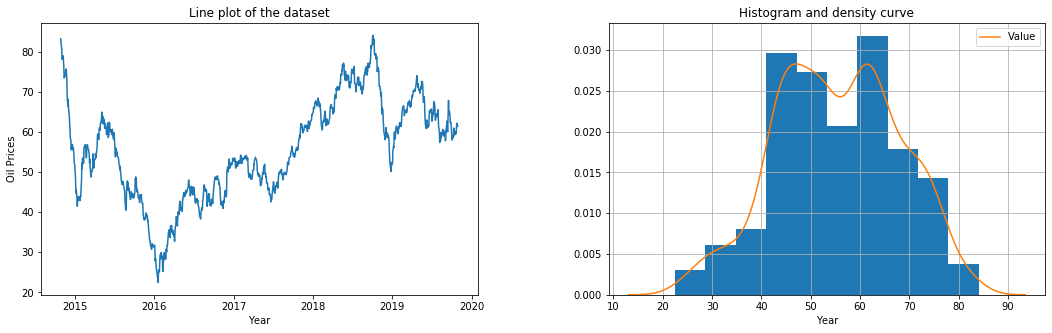

In [4]:
# Plotting line plot 
plt.rcParams['figure.figsize'] = 18,5
fig , (ax1, ax2) = plt.subplots(1,2)
ax1.plot(opec)
ax1.set_title('Line plot of the dataset')
ax1.set_xlabel('Year')
ax1.set_ylabel('Oil Prices')

# Plotting histogram and density curve
opec.hist(normed=True, ax=ax2)
sns.kdeplot(opec['Value'], ax=ax2)
ax2.set_title('Histogram and density curve')
ax2.set_xlabel('Year')

Based on the above plots, it is evident that there is a particular trend in our data. Also the data is not completely normal.<br>
However, this is a purely qualitative approach. Next let us explore a bit more quantitative check of stationarity.

### Method 2 - Summary statistics over different segments of the data.
In this method, we calculate the summary statistics, such as mean, over different segments of the data. If the statistics are changing drastically, then it means that the data is non-stationary.

In [5]:
# Grouping yearly and calculating its mean 
means_over_dataset = opec.groupby(by = opec.index.year).mean()
means_over_dataset

,Value
Date,
2014,68.092889
2015,49.504903
2016,40.759035
2017,52.429611
2018,69.781133
2019,63.934953


From this test, it is evident that the mean varies considerably with time. However, this is still a subjective notion. i.e. different individuals may have different notions as to what classifies as a significant change.<br>
Therefor, we need a more full proof test.

### Method 3 - Standard Statistical tests
There are 2 tests that can be utilized to judge the stationarity of a dataset.
- Augmented Dickey-Fuller Test (ADF Test)
- Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS Test)

#### ADF Test
- Null Hypothesis: $H0 =$ The series has a unit root (value of a =1). i.e. Data is **Non-Stationary** 
- Alternate Hypothesis: $H1 =$ The series does not have a unit root. i.e. Data is **Stationary** 

If the ADF value is less than the critical values, we reject $H0$ and vice versa.<br>
Or if the p value is less than the critical tolerance levels, 10%, 5% and 1%, then we reject $H0$ and vice versa.<br>

In [6]:
adf_test = adfuller(opec['Value'])
print("ADF Value- ", adf_test[0])
print("p Value - ", adf_test[1])
print("No. of Lags used - ", adf_test[2])
print("No. of Observations used - ", adf_test[3])
print("Critical Values - ", adf_test[4])

ADF Value-  -2.32503464942402
p Value -  0.1640208640440291
No. of Lags used -  7
No. of Observations used -  1282
Critical Values -  {'1%': -3.4354611091533913, '5%': -2.8637971193559992, '10%': -2.567971709132328}


Since the ADF value is greater than the critical values, we cannot reject $H0$. Also, the p value is greater than all critical levels. This is proof that $H0$ cannot be rejected and hence the data is **non-stationary** by ADF test.

#### KPSS Test
- Null Hypothesis: $H0 =$ Data is **Trend Stationary** 
- Alternate Hypothesis: $H1 =$ The series has a unit root. i.e. Data is **Non-Stationary** 

If the KPSS value is greater than the critical values, we reject $H0$ and vice versa.<br>
Or if the p value is less than the critical tolerance levels, 10%, 5% and 1%, then we reject $H0$ and vice versa.<br>

In [7]:
kpss_test = kpss(opec['Value'])
print("KPSS Value - ", kpss_test[0])
print("p Value - ", kpss_test[1])
print("No. of Lags used - ", kpss_test[2])
print("Critical Values - ", kpss_test[3])

KPSS Value -  2.48747901155041
p Value -  0.01
No. of Lags used -  23
Critical Values -  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


Since the KPSS value is greater than the critical values, we reject $H0$ and so the data is **non-stationary** by KPSS test too.

## Convert Non-Stationary data to Stationary data
This step is needed as most of the forecasting models work on stationary data only. In order to convert the data from non-stationary to stationary, we apply the differencing procedure.<br>
In this procedure, we take the difference between current data and previous data. The extent to which we go back in time in order to fetch previous data is defined by the **periods** attribute of the **diff()** function in **pandas** python library.<br>
For instance, in this case $periods=1$ so we take the difference of current value with the immediate predecessor.  

In [8]:
diff = opec['Value'].diff(periods=1)
opec_values_diff = diff[1:]
opec_values_diff.head()

Date
2014-10-30   -0.45
2014-10-31   -0.82
2014-11-03   -1.33
2014-11-04   -1.97
2014-11-05   -0.56
Name: Value, dtype: float64

On plotting the following data it is evident that it is stationary, since the summary statistics vary very little when compared to the original data.

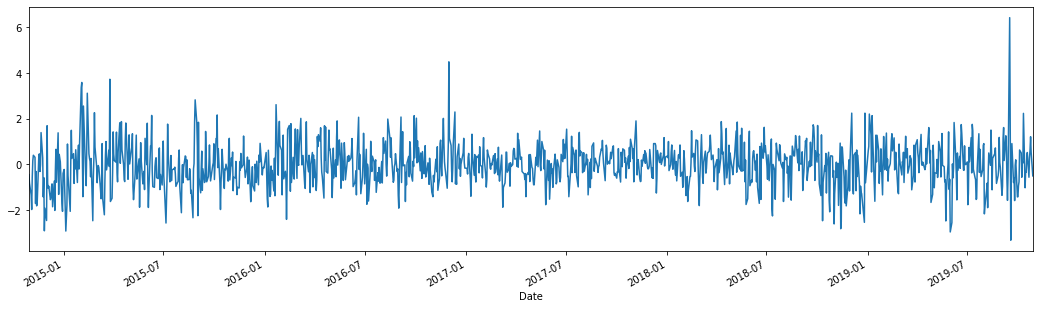

In [9]:
opec_values_diff.plot()

### Check for Stationarity
We recheck our transformed data for statinarity using the ADF and the KPSS tests 

In [10]:
adf_test_sqrt = adfuller(opec_values_diff.dropna())
print("ADF Value- ", adf_test_sqrt[0])
print("p Value - ", adf_test_sqrt[1])
print("No. of Lags used - ", adf_test_sqrt[2])
print("No. of Observations used - ", adf_test_sqrt[3])
print("Critical Values - ", adf_test_sqrt[4])
print("icbest (check meaning of this) - ", adf_test_sqrt[5])

ADF Value-  -16.09544510333972
p Value -  5.198989629225167e-29
No. of Lags used -  3
No. of Observations used -  1285
Critical Values -  {'1%': -3.4354491526385345, '5%': -2.8637918437278587, '10%': -2.5679688996048387}
icbest (check meaning of this) -  3336.6821075096964


In [11]:
kpss_test_sqrt = kpss(opec_values_diff.dropna())
print("KPSS Value - ", kpss_test_sqrt[0])
print("p Value - ", kpss_test_sqrt[1])
print("No. of Lags used - ", kpss_test_sqrt[2])
print("Critical Values - ", kpss_test_sqrt[3])

KPSS Value -  0.2567786035462193
p Value -  0.1
No. of Lags used -  23
Critical Values -  {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}


C:\Users\Yashveer\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


From both these tests it is quite evident that the transformed data is stationary. 

## Splitting Stationary Data into Training and Testing Sets
The oil prices recorded till 1<sup>st</sup> October, 2019 are used to train our model. All the values recorded since are used to test the accuracy of the model.

In [12]:
train = opec_values_diff[:'2019-08-01']
train.size

1226

In [13]:
test = opec_values_diff['2019-08-01':]
test.size

64

## ARIMA Model
The forecasting model used in this analysis is known as the arima model. The model stands for **AutoRegressive Integrated Moving Average**.<br>
The model has 3 hyperparameters - 
- p: The AutoRegressive model's parameter. It defines the no. of past obsevations that help determine the current observation.
- d: The order of differencing. It defines the order to which differencing operation needs to be carried out in order to make the data stationary. In our data we have already converted the data to a stationary form, so ideally this parameter should be 1.
- q: The Moving Average model's parameter. This is used to define the no. of white noise terms(of previous observations) that help to describe the current observation.

Through rough intuition we have come across the idea that $d=1$. In order to guess the value of $p$ and $q$ we can plot the partial auto correlation and the auto correlation graphs respectively.

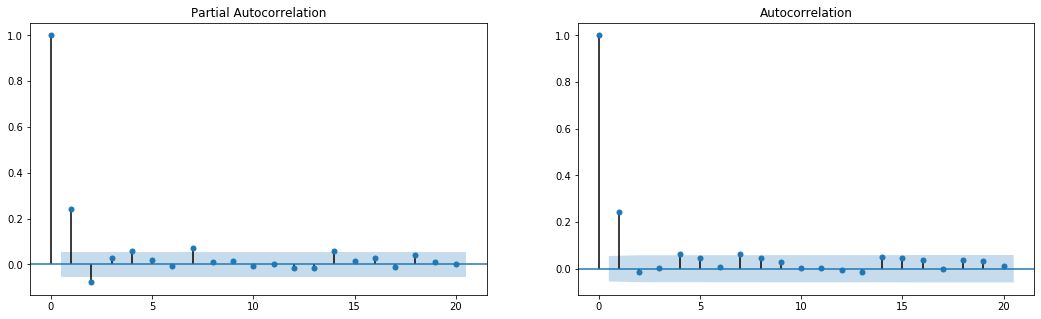

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2)

# Plotting partial autocorrelation
p = plot_pacf(opec_values_diff, lags=20, ax=ax1)
# Plotting autocorrelation
q = plot_acf(opec_values_diff, lags=20, ax=ax2)

Looking at the graphs it makes sense to guess the $p$ and $q$ values to be $1$ or $2$.
However, in order to get a better quantitative idea of the parameters, we will use grid search technique to find the optimal combination of hyperparameters.

### Parameter estimation using grid search
In order to find optimal parameters we define a range over which the parameters need to be estimated. In this example, the range would be $0, 1, 2$. Using the **product()** function in **itertools** library all possible combinaton of parameters are enumerated. 

In [15]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

Using the above list of all possible parameters, we build **ARIMA** models using the **ARIMA()** function in the **statsmodels** library. For each ARIMA model, the hyperparameters and the **AIC**(Akaike Information Critera) value of the model are stored in a dataframe named **param_df**  

In [16]:
warnings.filterwarnings('ignore')

param_df = pd.DataFrame(columns=['Parameter', 'AIC'])

i=0
for param in pdq:
    try:
        model_arima = ARIMA(train, order=param)
        model_arima_fit = model_arima.fit()
        param_df.loc[i] = [param, model_arima_fit.aic]
        i = i + 1
    except:
        continue

The set of parameters that give the minimum value of **AIC** are considered to be the optimal set of parameters.

In [17]:
param_df[param_df['AIC']==param_df['AIC'].min()]

,Parameter,AIC
10,"(1, 0, 2)",3202.265054


## Building the ARIMA model.
The optimal parameters uncovered are used to build the ARIMA model.

In [18]:
model_arima = ARIMA(train, order=(1, 0, 2))
model_arima_fit = model_arima.fit()

## Predicting future values.
The fitted model is used to forecast the future values(64 values) that span over the testing set. The **lower** and **upper** variables store the lower and upper confidence levels for the predictions. The confidence level is set to $alpha = 0.90$.

In [19]:
model_predictions = model_arima_fit.forecast(steps=64, alpha=0.90)

In [20]:
predict = model_predictions[0]

In [21]:
lower = model_predictions[2][:, 0]

In [22]:
upper = model_predictions[2][:, 1]

The predicted values are for the stationary(differenced) data that was used to train the model. The following code converts the predicted differenced values back to the original non-stationary data format.

In [23]:
predict_df = pd.DataFrame(columns=['Predictions', 'Lower', 'Upper'], index=opec.index[1226:])
predict_df['Predictions'][0] = opec['Value'][1226]
predict_df['Lower'][0] = opec['Value'][1226]
predict_df['Upper'][0] = opec['Value'][1226]

for i in range(1, 64):
    predict_df['Predictions'][i] = predict_df['Predictions'][i-1] + predict[i-1]
    predict_df['Lower'][i] = predict_df['Lower'][i-1] + lower[i-1]
    predict_df['Upper'][i] = predict_df['Upper'][i-1] + upper[i-1]

predict_df.head()

,Predictions,Lower,Upper
Date,,,
2019-08-01,63.37,63.37,63.37
2019-08-02,62.7804,62.6686,62.8921
2019-08-05,62.7232,62.496,62.9504
2019-08-06,62.668,62.3253,63.0107
2019-08-07,62.6148,62.1566,63.0729


In [24]:
index = list(predict_df.index)
lower = list(predict_df['Lower'])
upper = list(predict_df['Upper'])

## Comparing Predicted and Observed Data

### Method 1 - Graphical Comparision.
In the following graphs, the predicted values are compared with the overall dataset and the test dataset.

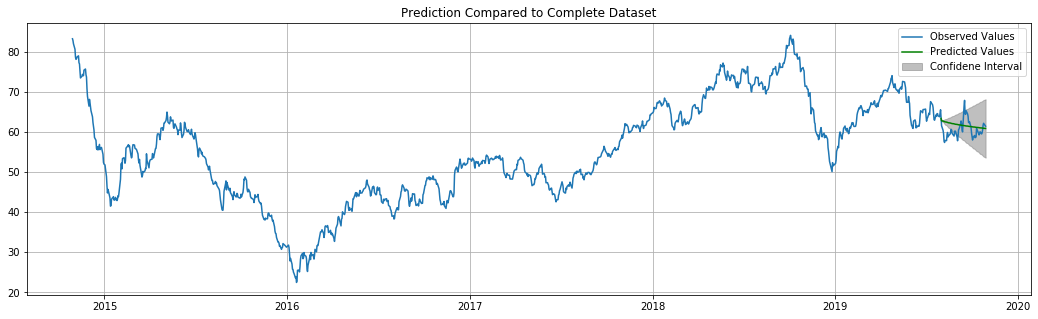

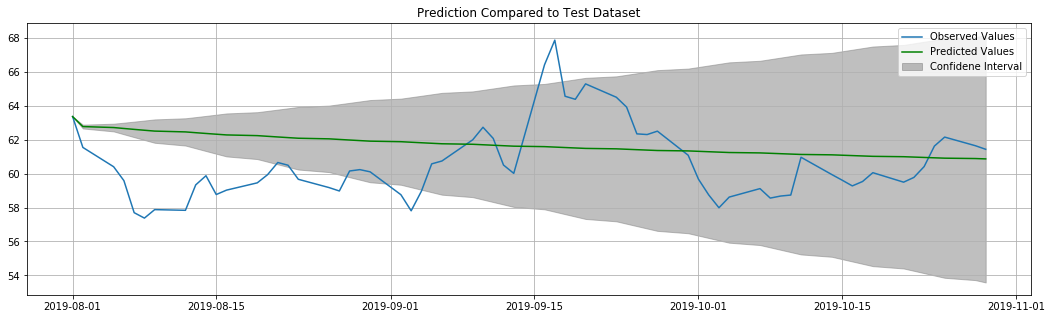

In [25]:
plt.plot(opec['Value'], label='Observed Values')
plt.plot(predict_df['Predictions'], color='green', label='Predicted Values')
plt.fill_between(index, lower, upper, color='grey', alpha=0.5, label='Confidene Interval')
plt.title('Prediction Compared to Complete Dataset')
plt.grid()
plt.legend()
plt.show()

plt.plot(opec['Value'][1226:], label='Observed Values')
plt.plot(predict_df['Predictions'], color='green', label='Predicted Values')
plt.fill_between(index, lower, upper, color='grey', alpha=0.5, label='Confidene Interval')
plt.title('Prediction Compared to Test Dataset')
plt.grid()
plt.legend()
plt.show()

### Method 2 - Chi-Square test for goodness of fit
The Chi-Squared statistic is used to test the goodness of the fit. It considers the following:
- Null Hypothesis or $H0$: The observed values are likely to have been from a distribution defined by the expected values.
- Alternative Hypothesis or $H1$: The observed values are not likely to have been from a distribution defined by the expected values.

The **p value** of this statistic defines the probability of observing the observed data from the distribution represented by the expected one.

In [26]:
observed_values = list(opec['Value'][1226:])
predicted_values = list(predict_df['Predictions'])

In [27]:
goodness_of_fit = chisquare(observed_values, f_exp=predicted_values)

In [28]:
print("Chi-Squared Statistic - ", goodness_of_fit[0])
print("p Value - ", goodness_of_fit[1])

Chi-Squared Statistic -  6.828924887312348
p Value -  1.0


The high **p value** indicates that the observed values could have been derived from the ARIMA model built. Thus it can be concluded that the model fits the data with reasonably well accuracy.

## References
- [Pearson's chi square test (goodness of fit) - Khan Academy](https://www.khanacademy.org/math/statistics-probability/inference-categorical-data-chi-square-tests/chi-square-goodness-of-fit-tests/v/pearson-s-chi-square-test-goodness-of-fit)
- [ARIMA models for time series forecasting - Statistical forecasting, Fuqua School of Business
Duke University](https://people.duke.edu/~rnau/411arim3.htm)
- [Time Series Visualization and Forecasting](https://www.digitalocean.com/community/tutorial_series/time-series-visualization-and-forecasting)
- [A Gentle Introduction to Handling a Non-Stationary Time Series in Python](https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/)
- [Forecasting: Principles and Practice, Rob J Hyndman and George Athanasopoulos, Monash University, Australia](https://otexts.com/fpp2/)